<a href="https://colab.research.google.com/github/Cooper-9/Notes-from-class/blob/main/(10/30)pivot_point_driven_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Simulate and analyze the motion of a rigid pendulum whose pivot point moves in a circular path about the pendulum bob.

**This notebook will describe and test various aspects of a pendulum's motion while having a pivot point being driven in a circular path.**

### Pseudocode
1. **Import needed modules:** from `matplotlib.animation` import `FuncAnimation`,
 `HTML` from `IPython.display`, `numpy` as np, and from `scipy.integrate` import `solve_ivp`.
2. **Define ODE function:** The differential equation describing the motion of the pendulum is given by... $\ddot{\theta} + 2{\gamma}\dot{\theta} + {\omega_0^2}(1+ \ddot{y_p})sin(\theta) + {\omega_0^2}*\ddot{x_p} cos(\theta) = 0 $
3. **Create utilities:**  `create_pendulum_animation` as well as plotting functions


In [111]:
# import modules
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad

### Solve equation of motion

In [112]:
# solve equation of motion

# parameters
omega_d = 20
g = l = 1
gamma = 0.05 # gamma now represents friction/damping
A = 1 # A represents the amplitude of the pivot's circular motion (Set to 1)
epsilon = 1 # epsilon represents the drive on the bob opposing the pivot motion
x_p0 , y_p0 = 0, 1
n_cycles = 20
initial_phase_pivot = np.pi / 2 # Set initial phase to start the pivot at the top

# time span for integration
t_min = 0
t_max = n_cycles * 2*np.pi / omega_d
t_span = [t_min, t_max]

# initial conditions
theta_0 = 0 # Set initial angle to 0 to start the pendulum at the bottom
ang_vel_0 = omega_d
y_0 = [theta_0, ang_vel_0]

# solve equation of motion
# The args tuple should now match the parameters expected by the modified pivot_driven_pendulum function
sol = solve_ivp(pivot_driven_pendulum, t_span, y_0, args=(omega_d, g, l, gamma, A, initial_phase_pivot, epsilon), method = 'Radau', dense_output = True) # Added epsilon to args

### Create pendulum animation

In [113]:
# create pendulum animation
def create_pendulum_animation(t, x_pivot, y_pivot, x_lab, y_lab, l=1, show_traj=False, speed_factor=1.0):
    """
    Creates an animation of the pivot-driven pendulum.

    PARAMETERS:
    t : ndarray
        Time array.
    x_pivot : ndarray
        x-positions of the pivot over time.
    y_pivot : ndarray
        y-positions of the pivot over time.
    x_lab : ndarray
        x-positions of the pendulum bob in the lab frame over time.
    y_lab : ndarray
        y-positions of the pendulum bob in the lab frame over time.
    l : float, optional
        pendulum length (default is 1).
    show_traj : bool, optional
        toggle showing the trajectory of the pendulum bob (default is False).
    speed_factor : float, optional
        factor to scale the animation speed (default is 1.0).
        a value > 1.0 slows down the animation, < 1.0 speeds it up.

    RETURNS:
    anim : FuncAnimation
        matplotlib animation object.
    """
    fig, ax = plt.subplots(figsize=(4, 4)) # Increased figure size
    ax.set_xlim(np.min(x_pivot) - l, np.max(x_pivot) + l)
    ax.set_ylim(np.min(y_pivot) - l, np.max(y_pivot) + l)
    # ax.set_aspect('equal', adjustable='box')
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # Initialize plot elements
    pivot, = ax.plot([], [], 'o', color='black', markersize=8, label='Pivot')
    pendulum_arm, = ax.plot([], [], '-', color='black', lw=2, label='Pendulum Arm')
    pendulum_bob, = ax.plot([], [], 'o', color='red', markersize=12, label='Pendulum Bob')
    trajectory = None # Initialize trajectory to None

    if show_traj:
        trajectory, = ax.plot([], [], '-', color='gray', lw=1, alpha=0.5, label='Trajectory') # Add trajectory line

    def animate(i):
        # Update the positions of the plot elements
        pivot.set_data([x_pivot[i]], [y_pivot[i]]) # Pass as sequences
        pendulum_arm.set_data([x_pivot[i], x_lab[i]], [y_pivot[i], y_lab[i]])
        pendulum_bob.set_data([x_lab[i]], [y_lab[i]]) # Pass as sequences

        artists = [pivot, pendulum_arm, pendulum_bob] # List of artists to update

        if show_traj and trajectory:
             trajectory.set_data(x_lab[:i+1], y_lab[:i+1]) # Update trajectory data
             artists.append(trajectory) # Add trajectory to the list of artists

        return artists # Return all updated artists

    # Create the animation
    # Adjust the interval based on the average time step in t
    # This aims to make the animation speed consistent with the simulation time
    average_time_step = np.mean(np.diff(t))
    # Scale the interval by the speed_factor
    interval = average_time_step * 1000 * speed_factor # Convert to milliseconds and apply speed_factor.

    anim = FuncAnimation(fig, animate, frames=len(t), interval=interval, blit=True)
    plt.close(fig) # Close the initial figure to prevent it from displaying

    return anim

### Animate pendulum motion

In [114]:
# animate motion
# plot pendulum angle versus time
# get coordinates for plotting
n_points = 300 # number of frames
t_plot = np.linspace(t_min, t_max, n_points)
theta_plot = sol.sol(t_plot)[0] # requires `dense_output=True` in `solve_ivp`
x_pivot, y_pivot = get_pivot_xy(t_plot, omega_d, x_p0, y_p0, A, initial_phase_pivot) # pivot coordinates - Added initial_phase_pivot
x_pendulum, y_pendulum = get_pendulum_xy(t_plot, theta_plot, l) # pendulum coordinates of pendulum (referenced to pivot point)
x_lab, y_lab = get_lab_xy(x_pivot, y_pivot, x_pendulum, y_pendulum) # pendulum coordinates in the lab frame

# animation flags/parameters
show_traj = True # True --> show trajectory; False --> do not show trajectory
speed_factor = 5 # >1 --> slow down animation; <1 --> speed up animation

# create_pendulum_animation
pendulum_animation = create_pendulum_animation(t_plot, x_pivot, y_pivot, x_lab, y_lab, show_traj=show_traj, speed_factor=speed_factor) # create animation object with trajectory shown
HTML(pendulum_animation.to_html5_video()) # display animation

### Bob motion over time

In [115]:
# define equation of motion
def pivot_driven_pendulum(t, y, omega_d, g, l, gamma, A, initial_phase_pivot, epsilon):
    """
    Defines the differential equation for the pivot-driven pendulum based on the pseudocode,
    including a term for epsilon.

    PARAMETERS:
    t : float
        Time.
    y : ndarray
        Array containing the current angle (y[0]) and angular velocity (y[1]).
    omega_d : float
        Driving frequency of the pivot.
    g : float
        Acceleration due to gravity.
    l : float
        Length of the pendulum arm.
    gamma : float
        Friction/damping coefficient.
    A : float
        Amplitude of the circular pivot motion.
    initial_phase_pivot : float, optional
        Initial phase of the pivot's circular motion.
    epsilon : float
        Parameter representing the drive on the bob opposing the pivot motion.

    RETURNS:
    dydt : list
        List containing the angular velocity and angular acceleration.
    """
    theta, ang_vel = y

    # Calculate the pivot's acceleration components using amplitude A and initial phase
    x_p_ddot = -A * omega_d**2 * np.cos(omega_d * t + initial_phase_pivot)
    y_p_ddot = -A * omega_d**2 * np.sin(omega_d * t + initial_phase_pivot)

    # Equation of motion from pseudocode: ddot(theta) + 2*gamma*dot(theta) + (g/l)*(1+ y_p_ddot/g)*sin(theta) + (g/l)*x_p_ddot/g * cos(theta) = 0
    # Rearranging to solve for ddot(theta):
    # ddot(theta) = -2*gamma*dot(theta) - (g/l)*sin(theta) - (y_p_ddot/l)*sin(theta) - (x_p_ddot/l)*cos(theta)

    # Incorporate epsilon: add a term proportional to the difference between the pendulum's
    # angular velocity and the pivot's angular velocity, opposing relative motion.
    # Assuming pivot's angular velocity is omega_d
    epsilon_term = -epsilon * (ang_vel - omega_d)


    d_ang_vel_dt = -2 * gamma * ang_vel - (g / l) * np.sin(theta) - (y_p_ddot / l) * np.sin(theta) - (x_p_ddot / l) * np.cos(theta) + epsilon_term

    return [ang_vel, d_ang_vel_dt]

# create utilities
def get_pivot_xy(t, omega_d, x_p0, y_p0, A=0.5, initial_phase_pivot=0):
    """
    Calculates the x and y coordinates of the pivot point over time.

    PARAMETERS:
    t : ndarray
        Time array.
    omega_d : float
        Driving frequency of the pivot.
    x_p0 : float
        Initial x-position of the pivot.
    y_p0 : float
        Initial y-position of the pivot.
    A : float, optional
        Amplitude of the circular pivot motion (default is 0.5).
    initial_phase_pivot : float, optional
        Initial phase of the pivot's circular motion (default is 0).


    RETURNS:
    x_pivot : ndarray
        x-coordinates of the pivot.
    y_pivot : ndarray
        y-coordinates of the pivot.
    """
    x_pivot = x_p0 + A * np.cos(omega_d * t + initial_phase_pivot)
    y_pivot = y_p0 + A * np.sin(omega_d * t + initial_phase_pivot)
    return x_pivot, y_pivot

def get_pendulum_xy(t, theta, l=1):
    """
    Calculates the x and y coordinates of the pendulum bob relative to the pivot.

    PARAMETERS:
    t : ndarray
        Time array.
    theta : ndarray
        Pendulum angle array.
    l : float, optional
        Length of the pendulum arm (default is 1).

    RETURNS:
    x_pendulum : ndarray
        x-coordinates of the pendulum bob relative to the pivot.
    y_pendulum : ndarray
        y-coordinates of the pendulum bob relative to the pivot.
    """
    x_pendulum = l * np.sin(theta)
    y_pendulum = -l * np.cos(theta)
    return x_pendulum, y_pendulum

def get_lab_xy(x_pivot, y_pivot, x_pendulum, y_pendulum):
    """
    Calculates the x and y coordinates of the pendulum bob in the lab frame.

    PARAMETERS:
    x_pivot : ndarray
        x-coordinates of the pivot.
    y_pivot : ndarray
        y-coordinates of the pivot.
    x_pendulum : ndarray
        x-coordinates of the pendulum bob relative to the pivot.
    y_pendulum : ndarray
        y-coordinates of the pendulum bob relative to the pivot.

    RETURNS:
    x_lab : ndarray
        x-coordinates of the pendulum bob in the lab frame.
    y_lab : ndarray
        y-coordinates of the pendulum bob in the lab frame.
    """
    x_lab = x_pivot + x_pendulum
    y_lab = y_pivot + y_pendulum
    return x_lab, y_lab

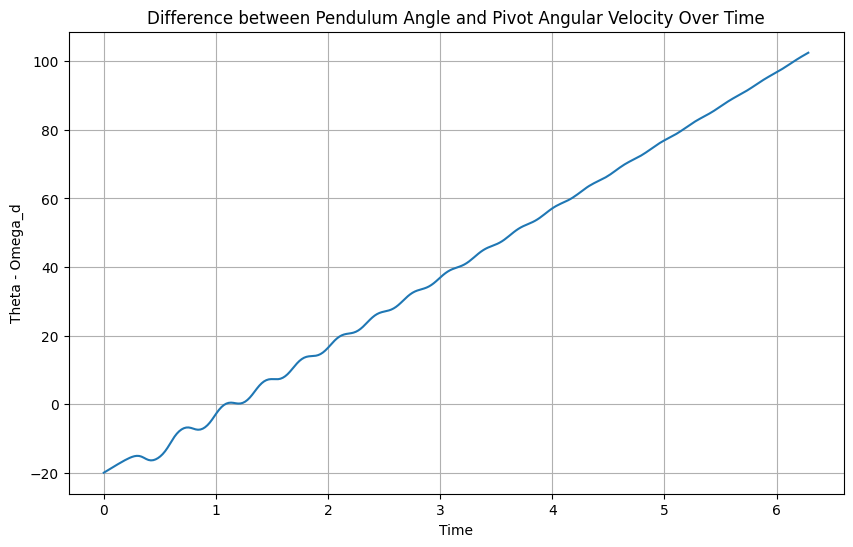

In [116]:
# Calculate the difference between pendulum angle and pivot angular velocity
theta_minus_omega_d = theta_plot - omega_d

# Plot the difference over time
plt.figure(figsize=(10, 6))
plt.plot(t_plot, theta_minus_omega_d)
plt.xlabel('Time')
plt.ylabel('Theta - Omega_d')
plt.title('Difference between Pendulum Angle and Pivot Angular Velocity Over Time')
plt.grid(True)
plt.show()

### I tried to replicate the sort of motion we found in class with the pendulum bob using the epsilon term, but for some reason I found that increasing epsilon by a considerable amount creates 'perfect' motion for the bob. At lower amounts (around 100) it seemed to work at first but eventually fall out of the center region.